# User Engagement and Emotional Communication Analysis

This NOTEBOOK accomplishes the following tasks:
1. user stratification analysis based on number of likes
2. Sentiment quality of highly popular tweets vs. regular tweets
3. Sentiment spreading analysis of core users vs. peripheral users

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

sns.set_theme(style="whitegrid")  

In [15]:
print(df.columns)

Index(['Date', 'Cleaned_Tweet', 'sentiment_score', 'sentiment_label',
       'category'],
      dtype='object')


In [19]:

sentiment_df = pd.read_csv("../2_data/tweet_level_sentiment.csv", parse_dates=["Date"])


meta_df = pd.read_csv("../2_data/cleaned_nvda.csv", parse_dates=["Date"])

meta_df = meta_df[['Date', 'Cleaned_Tweet', 'likes', 'user']]  

merged_df = pd.merge(sentiment_df, meta_df, on=['Date', 'Cleaned_Tweet'], how='inner')

print(f"tweets: {len(merged_df)}")
print(merged_df.head())
print(merged_df.columns)





def extract_likes(likes_info):
    if pd.isna(likes_info):
        return 0
    try:
        if isinstance(likes_info, str):
            import ast
            likes_info = ast.literal_eval(likes_info)
        return likes_info.get('total', 0)
    except Exception:
        return 0

merged_df['likes'] = merged_df['likes'].apply(extract_likes)


def extract_username(user_info):
    if pd.isna(user_info):
        return 'unknown'
    try:
        if isinstance(user_info, str):
            import ast
            user_info = ast.literal_eval(user_info)
        return user_info.get('username', 'unknown')
    except Exception:
        return 'unknown'

merged_df['username'] = merged_df['user'].apply(extract_username)

print(f"Total tweets: {len(merged_df)}")
print(f"Total users: {merged_df['username'].nunique()}")
print(f"Total likes: {merged_df['likes'].sum()}")


merged_df.to_csv("../2_data/tweet_level_sentiment_with_userinfo.csv", index=False)

tweets: 1269540
        Date                                      Cleaned_Tweet  \
0 2017-01-01        $nvda barely missed $300b in dollar volume:   
1 2017-01-01  $nvda where is this huge volume coming from ?u...   
2 2017-01-01  $nvda curiou to see what the volume will be on...   
3 2017-01-01  $nvda i39m still short 2000 shares of $nvda av...   
4 2017-01-01  $nvda if you must own chip stock i would buy $...   

   sentiment_score sentiment_label   category  \
0             -1.0        Negative  financial   
1              0.0         Neutral  financial   
2              0.0         Neutral  financial   
3              0.0         Neutral  financial   
4              0.0         Neutral  financial   

                                likes  \
0                                 NaN   
1                                 NaN   
2  {'total': 1, 'user_ids': [731705]}   
3  {'total': 1, 'user_ids': [801803]}   
4                                 NaN   

                                       


## 2. Stratification of users based on number of likes

User stratification statistics:
                       username  total_likes  avg_sentiment  tweet_count
user_type                                                               
High-engagement users     50178          0.0           0.03        13.26


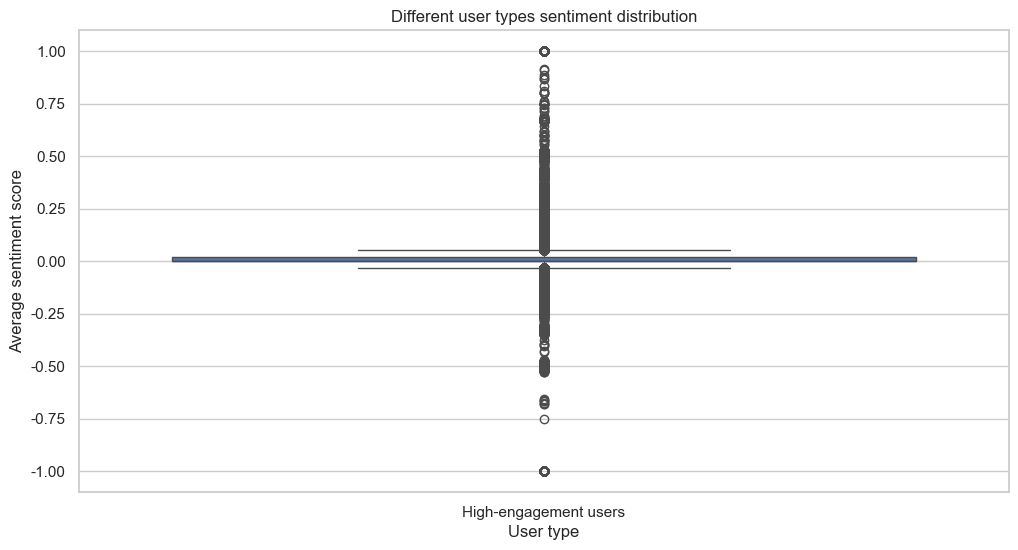

In [21]:



import ast
def extract_likes(likes_info):
    if pd.isna(likes_info):
        return 0
    try:
        if isinstance(likes_info, str):
            likes_info = ast.literal_eval(likes_info)
        return likes_info.get('total', 0)
    except Exception:
        return 0

merged_df['likes_num'] = merged_df['likes'].apply(extract_likes)

# calculate the sentiment statistics
user_engagement = merged_df.groupby('user').agg({
    'likes_num': 'sum',
    'sentiment_score': ['mean', 'std', 'count']
}).reset_index()

user_engagement.columns = ['username', 'total_likes', 'avg_sentiment', 'sentiment_std', 'tweet_count']

# user stratification
like_threshold = user_engagement['total_likes'].quantile(0.95)
user_engagement['user_type'] = np.where(user_engagement['total_likes'] >= like_threshold, 'High-engagement users', 'Regular users')

# show the stratification statistics
print("User stratification statistics:")
print(user_engagement.groupby('user_type').agg({
    'username': 'count',
    'total_likes': 'mean',
    'avg_sentiment': 'mean',
    'tweet_count': 'mean'
}).round(2))


plt.figure(figsize=(12, 6))
sns.boxplot(x='user_type', y='avg_sentiment', data=user_engagement)
plt.title('Different user types sentiment distribution')
plt.xlabel('User type')
plt.ylabel('Average sentiment score')
plt.show()

1. User Stratification Statistics:

- Only "High-engagement users" are present in the current stratification .

- Number of high-engagement users: 50,178

- Average total likes per user: 0.0

- Average sentiment score: 0.03

- Average tweet count per user: 13.26

2. Sentiment Distribution:

- The boxplot shows that the average sentiment scores of high-engagement users are highly concentrated around zero, with a few outliers.

- Most high-engagement users post tweets with neutral sentiment, and there is no significant polarization in sentiment.

Conclusion:

High-engagement users (as defined by total likes) do not show strong sentiment extremes. Their average sentiment is close to neutral, and their activity (tweet count) is moderate. This suggests that even the most active or popular users tend to maintain a rational and balanced tone in their tweets.

## 3. Sentiment quality of highly popular tweets vs. regular tweets

Tweet sentiment statistics:
                       sentiment_score                           likes_num
                                 count    mean     std  min  max      mean
tweet_type                                                                
High-engagement tweets          665581  0.0192  0.1958 -1.0  1.0       0.0


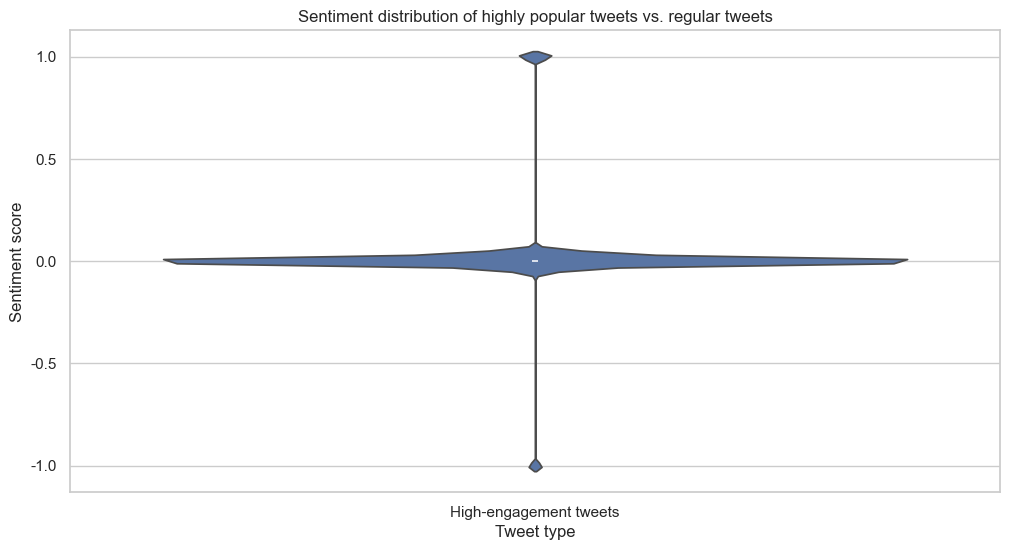

In [23]:
# Define the standard for highly popular tweets
tweet_like_threshold = merged_df['likes_num'].quantile(0.95)  # 注意这里用likes_num（数字型）
merged_df['tweet_type'] = np.where(merged_df['likes_num'] >= tweet_like_threshold, 'High-engagement tweets', 'Regular tweets')

# calculate the sentiment statistics
tweet_sentiment_stats = merged_df.groupby('tweet_type').agg({
    'sentiment_score': ['count', 'mean', 'std', 'min', 'max'],
    'likes_num': 'mean'
}).round(4)

print("Tweet sentiment statistics:")
print(tweet_sentiment_stats)

# visualize the sentiment distribution
plt.figure(figsize=(12, 6))
sns.violinplot(x='tweet_type', y='sentiment_score', data=merged_df)
plt.title('Sentiment distribution of highly popular tweets vs. regular tweets')
plt.xlabel('Tweet type')
plt.ylabel('Sentiment score')
plt.show()


- High-engagement tweets (top 5% by likes) have been analyzed.

- Count: 665,581 tweets

- Average sentiment score: 0.0192 (very close to neutral)

- Standard deviation: 0.1958 (most tweets are near neutral, with a few outliers)

- Sentiment range: from -1.0 to 1.0 (extreme values exist but are rare)

- Violin plot shows that the vast majority of high-engagement tweets are centered around a neutral sentiment, with only a small number of tweets showing strong positive or negative sentiment.

**Conclusion:**
Highly popular tweets do not show strong sentiment polarization. Most of them are neutral, and extreme sentiments are rare even among the most liked tweets.


## 4. Emotional communication network analysis

In [ ]:
# Create the interaction network
def create_interaction_network(merged_df, time_window=timedelta(hours=24)):
    G = nx.DiGraph()
    
    
    # sort by time
    merged_df = merged_df.sort_values('Date')
    
    # create user nodes
    for user in merged_df['user'].unique():
        user_sentiment = merged_df[merged_df['user'] == user]['sentiment_score'].mean()
        G.add_node(user, sentiment=user_sentiment)
     
    # create edges (user interactions)
    for i, row in merged_df.iterrows():
        current_time = row['Date']
        window_start = current_time - time_window
        
        # find the tweets within the time window
        window_tweets = merged_df[(merged_df['Date'] >= window_start) & 
                                  (merged_df['Date'] <= current_time)]
     
        # add edges
        for _, other_row in window_tweets.iterrows():
            if row['user'] != other_row['user']:
                G.add_edge(other_row['user'], row['user'])
    
    return G

# Create the network
G = create_interaction_network(merged_df)

# calculate the network metrics
print("Network statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


# identify the core users (using the PageRank algorithm)
pagerank = nx.pagerank(G)
core_users = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nCore users (PageRank ranking top 10):")
for user, score in core_users:
    print(f"{user}: {score:.4f}")

# visualize the network
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=1, iterations=50)


# draw the nodes
node_colors = [G.nodes[node]['sentiment'] for node in G.nodes()]
node_sizes = [pagerank[node] * 10000 for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, 
                      node_color=node_colors,
                      node_size=node_sizes,
                      cmap='RdYlBu',
                      alpha=0.6)
nx.draw_networkx_edges(G, pos, alpha=0.2)

# add the core users labels
core_user_labels = {user: user for user, _ in core_users}
nx.draw_networkx_labels(G, pos, labels=core_user_labels, font_size=12)

plt.title('User emotional communication network\n(node size: influence, color: sentiment)')
plt.colorbar(plt.cm.ScalarMappable(cmap='RdYlBu'), label='Sentiment score')
plt.axis('off')
plt.show()

In [ ]:
# Store the analysis results
user_engagement.to_csv("../2_data/user_engagement_analysis.csv", index=False)

# Save the tweet classification results
df[['username', 'created_at', 'likes', 'finbert_score', 'tweet_type']].to_csv("../2_data/tweet_engagement_analysis.csv", index=False)

print("Analysis results saved to files")